In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch

import gc
import cv2
import json
import pickle
import itertools
import numpy as np
import pandas as pd
from typing import Union
from scipy.ndimage import morphology
from torch.nn import functional as F
from torchvision.ops.boxes import batched_nms

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

sns.set_theme(style="ticks", color_codes=True)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [4]:
# def load_image(path, max_size=512, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
#     image = cv2.imread(path)
#     norm = (image[..., ::-1] / 255 - mean) / std
#     return resize(norm, max_size, max_size)

def load_image(path, max_size=512):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image, scale = resize(image, max_size, max_size)
    image = thresh(image)
    image = pad(image, max_size) / 255
    return image, scale

def resize(image, h, w):
    old_h, old_w, c = image.shape
    
    if old_w > old_h:
        new_w = w
        new_h = int(w / old_w * old_h)
    else:
        new_w = int(h / old_h * old_w)
        new_h = h
    
    image = cv2.resize(image, (new_w, new_h))
    return image, new_h / old_h

def thresh(image):
    mask = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask = cv2.GaussianBlur(mask,(5,5), 0)
    _, mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    mask = morphology.binary_closing(~mask, np.ones((3,3)))
    mask = morphology.binary_fill_holes(mask)
    
    image[~mask] = [0, 0, 0]
    return image

def pad(image, size, value=0):
    return np.pad(image, ((0, size - image.shape[0]), (0, size - image.shape[1]), (0,0)), mode='constant', constant_values=value)
    
class MalariaDataset(torch.utils.data.Dataset):
    labels = ['red blood cell', 'trophozoite', 'schizont', 'ring', 'leukocyte', 'gametocyte']

    def __init__(self, jsonPath, imagesDir):
        images = []
        self.annotations = []

        file = open(jsonPath)
        data = json.load(file)
        file.close

        for sample in tqdm(data):
            cordinates = []
            image, s = load_image(imagesDir + '/' + sample['image']['pathname'])
            gc.collect()
            
            for ob in sample['objects']:
                try:
                    label = MalariaDataset.labels.index(ob['category'])
                    bb = ob['bounding_box']
                    cordinates.append(torch.Tensor([bb['minimum']['c'] * s, bb['minimum']['r'] * s, bb['maximum']['c'] * s, bb['maximum']['r'] * s, label]))
                except ValueError:
                    pass
            
            images.append(torch.Tensor(image))
            self.annotations.append(torch.stack(cordinates))
        
        self.images = torch.stack(images).permute(0, 3, 1, 2)
        del images


    def __getitem__(self, index):
        return self.images[index], self.annotations[index]

    def __len__(self):
        return len(self.annotations)

In [ ]:
dataset = MalariaDataset('./malaria/training.json',
                         './malaria/')

100%|██████████| 1208/1208 [03:47<00:00,  5.31it/s]


In [ ]:
test_dataset = MalariaDataset('./malaria/test.json',
                              './malaria/')

100%|██████████| 120/120 [00:18<00:00,  6.63it/s]


In [ ]:
pickle.dump(dataset, open("./train_th.p", "wb"))

In [ ]:
pickle.dump(test_dataset, open("./test_th.p", "wb"))

In [5]:
dataset = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/efficentDet/train_th.p", "rb"))

In [6]:
test_dataset = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/efficentDet/test_th.p", "rb"))

In [7]:
def bn2d(ch):
    return torch.nn.BatchNorm2d(ch, momentum=0.01, eps=1e-3)

def drop():
    return torch.nn.Dropout(p=0.2)

class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))
    
class CustomSwish(torch.nn.Module):
    def forward(self, input_tensor):
        return Swish.apply(input_tensor)

class SeparableConvBlock(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.depth = torch.nn.Conv2d(in_channels, in_channels, 3, 1, 1, groups=in_channels, bias=False)
        self.point = torch.nn.Conv2d(in_channels, out_channels, 1, 1, 0)

    def forward(self, x):
        x = self.depth(x)
        x = self.point(x)
        return x

class MBConvBlock(torch.nn.Module):

    def __init__(self, in_channels, out_channels, filter_size, stride, padding, expansion_factor=6, se_factor=0.25):
        super().__init__()

        middle_size = in_channels * expansion_factor
        se_size = int(in_channels * se_factor)
        self.activation = CustomSwish()
        
        if expansion_factor != 1:
            self.first = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, middle_size, 1, 1, 0, bias=False),
                bn2d(middle_size),
                self.activation,
            )
        else:
            self.first = None
        
        self.second = torch.nn.Sequential(
            torch.nn.Conv2d(middle_size, middle_size, filter_size, stride, padding, bias=False, groups=middle_size),
            bn2d(middle_size),
            self.activation,
        )

        self.se = torch.nn.Sequential(
            torch.nn.AdaptiveAvgPool2d(1),
            torch.nn.Conv2d(middle_size, se_size, 1, 1, 0, bias=False),
            self.activation,
            torch.nn.Conv2d(se_size, middle_size, 1, 1, 0, bias=False),
            torch.nn.Sigmoid(),
        )

        self.third = torch.nn.Sequential(
            torch.nn.Conv2d(middle_size, out_channels, 1, 1, 0, bias=False),
            bn2d(out_channels),
        )

        if in_channels != out_channels or stride != 1:
            self.downsample = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, 1, stride, 0, bias=False),
                bn2d(out_channels),
            )
        else:
            self.downsample = None

        self.drop = drop()

    def forward(self, x):
        resedual = x

        if self.first != None:
            x = self.first(x)

        x = self.second(x)
        x = self.se(x) * x
        x = self.third(x)

        if self.downsample != None:
            resedual = self.downsample(resedual)

        x = x + resedual
        x = self.activation(x)
        x = self.drop(x)

        return x

In [8]:
class EfficientNet(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.conv_1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, 3, 2, 1, bias=False),
            bn2d(32),
            CustomSwish(),
        )

        self.p3 = torch.nn.Sequential(
            MBConvBlock( 32,  16, 3, 1, 1, 1), # 256

            MBConvBlock( 16,  24, 3, 2, 1, 6), # 128
            MBConvBlock( 24,  24, 3, 1, 1, 6), # 128

            MBConvBlock( 24,  40, 5, 2, 2, 6), # 64
            MBConvBlock( 40,  40, 5, 1, 2, 6), # 64
        )

        self.p4 = torch.nn.Sequential(
            MBConvBlock( 40,  80, 3, 2, 1, 6), # 32
            MBConvBlock( 80,  80, 3, 1, 1, 6), # 32
            MBConvBlock( 80,  80, 3, 1, 1, 6), # 32

            MBConvBlock( 80, 112, 5, 1, 2, 6), # 32
            MBConvBlock(112, 112, 5, 1, 2, 6), # 32
            MBConvBlock(112, 112, 5, 1, 2, 6), # 32
        )

        self.p5 = torch.nn.Sequential(
            MBConvBlock(112, 192, 5, 2, 2, 6), # 16
            MBConvBlock(192, 192, 5, 1, 2, 6), # 16
            MBConvBlock(192, 192, 5, 1, 2, 6), # 16
            MBConvBlock(192, 192, 5, 1, 2, 6), # 16

            MBConvBlock(192, 320, 3, 1, 1, 6), # 16
        )

        self.p6 = torch.nn.Sequential(
            torch.nn.Conv2d(320, 64, 1, 1, 0, bias=False),
            bn2d(64),
            torch.nn.MaxPool2d(3, 2, 1),
        )

        self.p7 = torch.nn.Sequential(
            torch.nn.MaxPool2d(3, 2, 1),
        )

    def forward(self, x):
        x = self.conv_1(x)

        p3 = self.p3(x)
        p4 = self.p4(p3)
        p5 = self.p5(p4)
        p6 = self.p6(p5)
        p7 = self.p7(p6)

        return (p3, p4, p5, p6, p7)

In [9]:
class BiFPN(torch.nn.Module):

    def __init__(self, downsample=True):
        super().__init__()

        self.w4_1 = torch.nn.Parameter(torch.ones(2, dtype=torch.float32), requires_grad=True)
        self.w5_1 = torch.nn.Parameter(torch.ones(2, dtype=torch.float32), requires_grad=True)
        self.w6_1 = torch.nn.Parameter(torch.ones(2, dtype=torch.float32), requires_grad=True)

        self.w3_2 = torch.nn.Parameter(torch.ones(2, dtype=torch.float32), requires_grad=True)
        self.w4_2 = torch.nn.Parameter(torch.ones(3, dtype=torch.float32), requires_grad=True)
        self.w5_2 = torch.nn.Parameter(torch.ones(3, dtype=torch.float32), requires_grad=True)
        self.w6_2 = torch.nn.Parameter(torch.ones(3, dtype=torch.float32), requires_grad=True)
        self.w7_2 = torch.nn.Parameter(torch.ones(2, dtype=torch.float32), requires_grad=True)

        if downsample:
            self.downsample = True
            self.p5_downsample = torch.nn.Conv2d(320, 64, 1, 1, 0, bias=False)
            self.p4_downsample = torch.nn.Conv2d(112, 64, 1, 1, 0, bias=False)
            self.p3_downsample = torch.nn.Conv2d( 40, 64, 1, 1, 0, bias=False)
        else:
            self.downsample = False
        
        swish = CustomSwish()

        self.conv_p4_1 = torch.nn.Sequential(SeparableConvBlock(64, 64), bn2d(64), swish)
        self.conv_p5_1 = torch.nn.Sequential(SeparableConvBlock(64, 64), bn2d(64), swish)
        self.conv_p6_1 = torch.nn.Sequential(SeparableConvBlock(64, 64), bn2d(64), swish)

        self.conv_p3_2 = torch.nn.Sequential(SeparableConvBlock(64, 64), bn2d(64), swish)
        self.conv_p4_2 = torch.nn.Sequential(SeparableConvBlock(64, 64), bn2d(64), swish)
        self.conv_p5_2 = torch.nn.Sequential(SeparableConvBlock(64, 64), bn2d(64), swish)
        self.conv_p6_2 = torch.nn.Sequential(SeparableConvBlock(64, 64), bn2d(64), swish)
        self.conv_p7_2 = torch.nn.Sequential(SeparableConvBlock(64, 64), bn2d(64), swish)

        self.upscale = torch.nn.Upsample(scale_factor=2, mode='nearest')
        self.dwscale = torch.nn.MaxPool2d(3, 2, 1)

        self.activation = swish
    
    def _fusion(self, nodes, weights):
        temp = 0

        for w, p in zip(nodes, weights):
            temp += w * p

        return temp / (weights.sum() + 1e-4)

    def forward(self, x):
        p3, p4, p5, p6, p7 = x

        if self.downsample:
            p3 = self.p3_downsample(p3)
            p4 = self.p4_downsample(p4)
            p5 = self.p5_downsample(p5)
        
        p6_1 = self.conv_p6_1(self._fusion([self.upscale(p7),   p6], self.w6_1))
        p5_1 = self.conv_p5_1(self._fusion([self.upscale(p6_1), p5], self.w5_1))
        p4_1 = self.conv_p4_1(self._fusion([self.upscale(p5_1), p4], self.w4_1))

        p3_2 = self.conv_p3_2(self._fusion([      self.upscale(p4_1), p3], self.w3_2))
        p4_2 = self.conv_p4_2(self._fusion([self.dwscale(p3_2), p4_1, p4], self.w4_2))
        p5_2 = self.conv_p5_2(self._fusion([self.dwscale(p4_2), p5_1, p5], self.w5_2))
        p6_2 = self.conv_p6_2(self._fusion([self.dwscale(p5_2), p6_1, p6], self.w6_2))
        p7_2 = self.conv_p7_2(self._fusion([self.dwscale(p6_2),       p7], self.w7_2))
        
        return (p3_2, p4_2, p5_2, p6_2, p7_2)

In [10]:
class ClassPredictionNet(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        activation = CustomSwish()

        self.levels = torch.nn.ModuleList([
            torch.nn.Sequential(*[torch.nn.Sequential(SeparableConvBlock(64, 64), bn2d(64), activation) for i in range(3)]) for j in range(5)
        ])

        self.header = SeparableConvBlock(64, self.num_classes * 9)
        

    def forward(self, x):
        ff = []

        for f, level in zip(x, self.levels):
            f = self.header(level(f))
            f = f.permute(0, 2, 3, 1)
            f = f.contiguous().view(f.shape[0], f.shape[1], f.shape[2], 9, self.num_classes)
            f = f.contiguous().view(f.shape[0], -1, self.num_classes)

            ff.append(f)
        
        x = torch.cat(ff, dim=1)
        x = x.sigmoid()

        return x

In [11]:
class BoxPredictionNet(torch.nn.Module):

    def __init__(self):
        super().__init__()

        activation = CustomSwish()

        self.levels = torch.nn.ModuleList([
            torch.nn.Sequential(*[torch.nn.Sequential(SeparableConvBlock(64, 64), bn2d(64), activation) for i in range(3)]) for j in range(5)
        ])

        self.header = SeparableConvBlock(64, 36)
        

    def forward(self, x):
        ff = []

        for f, level in zip(x, self.levels):
            f = self.header(level(f))
            f = f.permute(0, 2, 3, 1)
            f = f.contiguous().view(f.shape[0], -1, 4)

            ff.append(f)
        
        x = torch.cat(ff, dim=1)

        return x

In [12]:
class Anchors(torch.nn.Module):
    # https://github.com/google/automl/blob/7c9d26d96c69ad8bff9413bc34bc2639ddb40e38/efficientdet/keras/anchors.py
    

    def __init__(self, anchor_scale=4., pyramid_levels=None):
        super().__init__()
        self.anchor_scale = anchor_scale

        if pyramid_levels is None:
            self.pyramid_levels = [3, 4, 5, 6, 7]
        else:
            self.pyramid_levels = pyramid_levels

        self.strides = [2 ** x for x in self.pyramid_levels]
        self.scales = np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])
        self.ratios = [(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)]

        self.last_anchors = {}
        self.last_shape = None

    def forward(self, image, dtype=torch.float32):
        """Generates multiscale anchor boxes.

        Args:
          image_size: integer number of input image size. The input image has the
            same dimension for width and height. The image_size should be divided by
            the largest feature stride 2^max_level.
          anchor_scale: float number representing the scale of size of the base
            anchor to the feature stride 2^level.
          anchor_configs: a dictionary with keys as the levels of anchors and
            values as a list of anchor configuration.

        Returns:
          anchor_boxes: a numpy array with shape [N, 4], which stacks anchors on all
            feature levels.
        Raises:
          ValueError: input size must be the multiple of largest feature stride.
        """
        image_shape = image.shape[2:]

        if image_shape == self.last_shape and image.device in self.last_anchors:
            return self.last_anchors[image.device]

        if self.last_shape is None or self.last_shape != image_shape:
            self.last_shape = image_shape

        if dtype == torch.float16:
            dtype = np.float16
        else:
            dtype = np.float32

        boxes_all = []
        for stride in self.strides:
            boxes_level = []
            for scale, ratio in itertools.product(self.scales, self.ratios):
                if image_shape[1] % stride != 0:
                    raise ValueError('input size must be divided by the stride.')
                base_anchor_size = self.anchor_scale * stride * scale
                anchor_size_x_2 = base_anchor_size * ratio[0] / 2.0
                anchor_size_y_2 = base_anchor_size * ratio[1] / 2.0

                x = np.arange(stride / 2, image_shape[1], stride)
                y = np.arange(stride / 2, image_shape[0], stride)
                xv, yv = np.meshgrid(x, y)
                xv = xv.reshape(-1)
                yv = yv.reshape(-1)

                # y1,x1,y2,x2
                boxes = np.vstack((yv - anchor_size_y_2, xv - anchor_size_x_2,
                                   yv + anchor_size_y_2, xv + anchor_size_x_2))
                boxes = np.swapaxes(boxes, 0, 1)
                boxes_level.append(np.expand_dims(boxes, axis=1))
            # concat anchors on the same level to the reshape NxAx4
            boxes_level = np.concatenate(boxes_level, axis=1)
            boxes_all.append(boxes_level.reshape([-1, 4]))

        anchor_boxes = np.vstack(boxes_all)

        anchor_boxes = torch.from_numpy(anchor_boxes.astype(dtype)).to(image.device)
        anchor_boxes = anchor_boxes.unsqueeze(0)

        # save it for later use to reduce overhead
        self.last_anchors[image.device] = anchor_boxes
        return anchor_boxes

In [13]:
class EfficientDet(torch.nn.Module):

    def __init__(self, num_classes=2):
        super().__init__()

        self.backbone = EfficientNet()
        self.biFPNs = torch.nn.Sequential(
            BiFPN(True), BiFPN(False), BiFPN(False),
        )
        self.classNet = ClassPredictionNet(num_classes)
        self.boxNet = BoxPredictionNet()

    def forward(self, x):
        x = self.backbone(x)
        x = self.biFPNs(x)

        classes = self.classNet(x)
        boxes = self.boxNet(x)

        return x, classes, boxes

In [14]:
class BBoxTransform(torch.nn.Module):
    def forward(self, anchors, regression):
        """
        decode_box_outputs adapted from https://github.com/google/automl/blob/master/efficientdet/anchors.py

        Args:
            anchors: [batchsize, boxes, (y1, x1, y2, x2)]
            regression: [batchsize, boxes, (dy, dx, dh, dw)]

        Returns:

        """
        y_centers_a = (anchors[..., 0] + anchors[..., 2]) / 2
        x_centers_a = (anchors[..., 1] + anchors[..., 3]) / 2
        ha = anchors[..., 2] - anchors[..., 0]
        wa = anchors[..., 3] - anchors[..., 1]

        w = regression[..., 3].exp() * wa
        h = regression[..., 2].exp() * ha

        y_centers = regression[..., 0] * ha + y_centers_a
        x_centers = regression[..., 1] * wa + x_centers_a

        ymin = y_centers - h / 2.
        xmin = x_centers - w / 2.
        ymax = y_centers + h / 2.
        xmax = x_centers + w / 2.

        return torch.stack([xmin, ymin, xmax, ymax], dim=2)


class ClipBoxes(torch.nn.Module):

    def __init__(self):
        super(ClipBoxes, self).__init__()

    def forward(self, boxes, img):
        batch_size, num_channels, height, width = img.shape

        boxes[:, :, 0] = torch.clamp(boxes[:, :, 0], min=0)
        boxes[:, :, 1] = torch.clamp(boxes[:, :, 1], min=0)

        boxes[:, :, 2] = torch.clamp(boxes[:, :, 2], max=width - 1)
        boxes[:, :, 3] = torch.clamp(boxes[:, :, 3], max=height - 1)

        return boxes

def postprocess(x, anchors, regression, classification, regressBoxes, clipBoxes, threshold, iou_threshold):
    transformed_anchors = regressBoxes(anchors, regression)
    transformed_anchors = clipBoxes(transformed_anchors, x)
    scores = torch.max(classification, dim=2, keepdim=True)[0]
    scores_over_thresh = (scores > threshold)[:, :, 0]
    out = []
    for i in range(x.shape[0]):
        if scores_over_thresh[i].sum() == 0:
            out.append({
                'rois': np.array(()),
                'class_ids': np.array(()),
                'scores': np.array(()),
            })
            continue

        classification_per = classification[i, scores_over_thresh[i, :], ...].permute(1, 0)
        transformed_anchors_per = transformed_anchors[i, scores_over_thresh[i, :], ...]
        scores_per = scores[i, scores_over_thresh[i, :], ...]
        scores_, classes_ = classification_per.max(dim=0)
        anchors_nms_idx = batched_nms(transformed_anchors_per, scores_per[:, 0], classes_, iou_threshold=iou_threshold)

        if anchors_nms_idx.shape[0] != 0:
            classes_ = classes_[anchors_nms_idx]
            scores_ = scores_[anchors_nms_idx]
            boxes_ = transformed_anchors_per[anchors_nms_idx, :]

            out.append({
                'rois': boxes_.cpu().numpy(),
                'class_ids': classes_.cpu().numpy(),
                'scores': scores_.cpu().numpy(),
            })
        else:
            out.append({
                'rois': np.array(()),
                'class_ids': np.array(()),
                'scores': np.array(()),
            })

    return out

def invert_affine(metas: Union[float, list, tuple], preds):
    for i in range(len(preds)):
        if len(preds[i]['rois']) == 0:
            continue
        else:
            if metas is float:
                preds[i]['rois'][:, [0, 2]] = preds[i]['rois'][:, [0, 2]] / metas
                preds[i]['rois'][:, [1, 3]] = preds[i]['rois'][:, [1, 3]] / metas
            else:
                new_w, new_h, old_w, old_h, padding_w, padding_h = metas[i]
                preds[i]['rois'][:, [0, 2]] = preds[i]['rois'][:, [0, 2]] / (new_w / old_w)
                preds[i]['rois'][:, [1, 3]] = preds[i]['rois'][:, [1, 3]] / (new_h / old_h)
    return preds

In [15]:
def calc_iou(a, b):
    # a(anchor) [boxes, (y1, x1, y2, x2)]
    # b(gt, coco-style) [boxes, (x1, y1, x2, y2)]

    area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])
    iw = torch.min(torch.unsqueeze(a[:, 3], dim=1), b[:, 2]) - torch.max(torch.unsqueeze(a[:, 1], 1), b[:, 0])
    ih = torch.min(torch.unsqueeze(a[:, 2], dim=1), b[:, 3]) - torch.max(torch.unsqueeze(a[:, 0], 1), b[:, 1])
    iw = torch.clamp(iw, min=0)
    ih = torch.clamp(ih, min=0)
    ua = torch.unsqueeze((a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1]), dim=1) + area - iw * ih
    ua = torch.clamp(ua, min=1e-8)
    intersection = iw * ih
    IoU = intersection / ua

    return IoU

class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, classifications, regressions, anchors, annotations, **kwargs):
        alpha = self.alpha
        gamma = self.gamma
        batch_size = classifications.shape[0]
        classification_losses = []
        regression_losses = []

        anchor = anchors[0, :, :]
        dtype = anchors.dtype

        anchor_widths = anchor[:, 3] - anchor[:, 1]
        anchor_heights = anchor[:, 2] - anchor[:, 0]
        anchor_ctr_x = anchor[:, 1] + 0.5 * anchor_widths
        anchor_ctr_y = anchor[:, 0] + 0.5 * anchor_heights

        for j in range(batch_size):

            classification = classifications[j, :, :]
            regression = regressions[j, :, :]

            bbox_annotation = annotations[j]
            bbox_annotation = bbox_annotation[bbox_annotation[:, 4] != -1]

            classification = torch.clamp(classification, 1e-4, 1.0 - 1e-4)
            
            if bbox_annotation.shape[0] == 0:
                if torch.cuda.is_available():
                    
                    alpha_factor = torch.ones_like(classification) * alpha
                    alpha_factor = alpha_factor.cuda()
                    alpha_factor = 1. - alpha_factor
                    focal_weight = classification
                    focal_weight = alpha_factor * torch.pow(focal_weight, gamma)
                    
                    bce = -(torch.log(1.0 - classification))
                    
                    cls_loss = focal_weight * bce
                    
                    regression_losses.append(torch.tensor(0).to(dtype).cuda())
                    classification_losses.append(cls_loss.sum())
                else:
                    
                    alpha_factor = torch.ones_like(classification) * alpha
                    alpha_factor = 1. - alpha_factor
                    focal_weight = classification
                    focal_weight = alpha_factor * torch.pow(focal_weight, gamma)
                    
                    bce = -(torch.log(1.0 - classification))
                    
                    cls_loss = focal_weight * bce
                    
                    regression_losses.append(torch.tensor(0).to(dtype))
                    classification_losses.append(cls_loss.sum())

                continue
                
            IoU = calc_iou(anchor[:, :], bbox_annotation[:, :4])

            IoU_max, IoU_argmax = torch.max(IoU, dim=1)

            # compute the loss for classification
            targets = torch.ones_like(classification) * -1
            if torch.cuda.is_available():
                targets = targets.cuda()

            targets[torch.lt(IoU_max, 0.4), :] = 0

            positive_indices = torch.ge(IoU_max, 0.5)

            num_positive_anchors = positive_indices.sum()

            assigned_annotations = bbox_annotation[IoU_argmax, :]

            targets[positive_indices, :] = 0
            targets[positive_indices, assigned_annotations[positive_indices, 4].long()] = 1

            alpha_factor = torch.ones_like(targets) * alpha
            if torch.cuda.is_available():
                alpha_factor = alpha_factor.cuda()

            alpha_factor = torch.where(torch.eq(targets, 1.), alpha_factor, 1. - alpha_factor)
            focal_weight = torch.where(torch.eq(targets, 1.), 1. - classification, classification)
            focal_weight = alpha_factor * torch.pow(focal_weight, gamma)

            bce = -(targets * torch.log(classification) + (1.0 - targets) * torch.log(1.0 - classification))

            cls_loss = focal_weight * bce

            zeros = torch.zeros_like(cls_loss)
            if torch.cuda.is_available():
                zeros = zeros.cuda()
            cls_loss = torch.where(torch.ne(targets, -1.0), cls_loss, zeros)

            classification_losses.append(cls_loss.sum() / torch.clamp(num_positive_anchors.to(dtype), min=1.0))

            if positive_indices.sum() > 0:
                assigned_annotations = assigned_annotations[positive_indices, :]

                anchor_widths_pi = anchor_widths[positive_indices]
                anchor_heights_pi = anchor_heights[positive_indices]
                anchor_ctr_x_pi = anchor_ctr_x[positive_indices]
                anchor_ctr_y_pi = anchor_ctr_y[positive_indices]

                gt_widths = assigned_annotations[:, 2] - assigned_annotations[:, 0]
                gt_heights = assigned_annotations[:, 3] - assigned_annotations[:, 1]
                gt_ctr_x = assigned_annotations[:, 0] + 0.5 * gt_widths
                gt_ctr_y = assigned_annotations[:, 1] + 0.5 * gt_heights

                # efficientdet style
                gt_widths = torch.clamp(gt_widths, min=1)
                gt_heights = torch.clamp(gt_heights, min=1)

                targets_dx = (gt_ctr_x - anchor_ctr_x_pi) / anchor_widths_pi
                targets_dy = (gt_ctr_y - anchor_ctr_y_pi) / anchor_heights_pi
                targets_dw = torch.log(gt_widths / anchor_widths_pi)
                targets_dh = torch.log(gt_heights / anchor_heights_pi)

                targets = torch.stack((targets_dy, targets_dx, targets_dh, targets_dw))
                targets = targets.t()

                regression_diff = torch.abs(targets - regression[positive_indices, :])

                regression_loss = torch.where(
                    torch.le(regression_diff, 1.0 / 9.0),
                    0.5 * 9.0 * torch.pow(regression_diff, 2),
                    regression_diff - 0.5 / 9.0
                )
                regression_losses.append(regression_loss.mean())
            else:
                if torch.cuda.is_available():
                    regression_losses.append(torch.tensor(0).to(dtype).cuda())
                else:
                    regression_losses.append(torch.tensor(0).to(dtype))

        return torch.stack(classification_losses).mean(dim=0, keepdim=True), \
               torch.stack(regression_losses).mean(dim=0, keepdim=True) * 50

# Train the model

In [19]:
BATCH_SIZE = 16

# dataset_size = len(dataset)
# validation_size = dataset_size * 2 // 10
# train_size = dataset_size - validation_size
# train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size])

def collater(data):
    return torch.stack([d[0] for d in data]), [d[1] for d in data]

train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, collate_fn=collater)
validation_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True, collate_fn=collater)

In [22]:
model = EfficientDet(len(MalariaDataset.labels)).to(device)
criterion = FocalLoss(3.0,0.1).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=4e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [23]:
epoch_history = pd.DataFrame(columns=['train_reg_loss', 'train_class_loss',
                                      'train_loss', 'validation_reg_loss',
                                      'validation_class_loss',
                                      'validation_loss', 'lr'])

In [35]:
gc.collect()
torch.cuda.empty_cache()

anchor = Anchors().to(device)

for epoch in tqdm(range(70), desc='Epochs', leave=True):

    train_cls, train_reg, train_total = [], [], []
    model.train()

    for inputs, labels in tqdm(train_loader, desc='Batches', leave=False):
        
        inputs, labels = inputs.to(device), [l.to(device) for l in labels]

        optimizer.zero_grad()
        _, classes, boxes = model(inputs)
        anchors = anchor(inputs)
        cls_loss, reg_loss = criterion(classes, boxes, anchors, labels)

        cls_loss = cls_loss.mean()
        reg_loss = reg_loss.mean()

        loss = cls_loss + reg_loss

        loss.backward()
        optimizer.step()

        train_cls.append(cls_loss.item())
        train_reg.append(reg_loss.item())
        train_total.append(loss.item())

    with torch.no_grad():

        validation_cls, validation_reg, validation_total = [], [], []
        model.eval()

        for inputs, labels in tqdm(validation_loader, desc='Batches', leave=False):

            inputs, labels = inputs.to(device), [l.to(device) for l in labels]

            _, classes, boxes = model(inputs)
            anchors = anchor(inputs)
            cls_loss, reg_loss = criterion(classes, boxes, anchors, labels)

            cls_loss = cls_loss.mean()
            reg_loss = reg_loss.mean()

            loss = cls_loss + reg_loss

            validation_cls.append(cls_loss.item())
            validation_reg.append(reg_loss.item())
            validation_total.append(loss.item())
    
    ep = [
          np.mean(train_reg),
          np.mean(train_cls),
          np.mean(train_total),

          np.mean(validation_reg),
          np.mean(validation_cls),
          np.mean(validation_total),

          optimizer.param_groups[0]['lr'],
    ]

    scheduler.step(ep[5])
    epoch_history = epoch_history.append(dict(zip(epoch_history.columns, ep)), ignore_index=True)
    tqdm.write("epoch %d | loss: %.5f %.5f" % (epoch + 1, ep[2], ep[5]))
    torch.save(model, '/content/drive/MyDrive/Colab Notebooks/efficentDet/model-test-full-last.pth')

print('Finished Training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  app.launch_new_instance()


epoch 1 | loss: 1.06897 1.29382


epoch 2 | loss: 1.05719 1.27544


epoch 3 | loss: 1.04804 1.25815


epoch 4 | loss: 1.03447 1.26249


epoch 5 | loss: 1.02569 1.25828


epoch 6 | loss: 1.02047 1.25182


epoch 7 | loss: 1.01000 1.25763


epoch 8 | loss: 1.00663 1.32605


epoch 9 | loss: 1.00805 1.23766


epoch 10 | loss: 0.98588 1.24024


epoch 11 | loss: 0.98080 1.23007


epoch 12 | loss: 0.97070 1.20918


epoch 13 | loss: 0.95962 1.21749


epoch 14 | loss: 0.95734 1.22374


epoch 15 | loss: 0.95754 1.21741


epoch 16 | loss: 0.94759 1.19582


epoch 17 | loss: 0.93872 1.19128


epoch 18 | loss: 0.93616 1.23354


epoch 19 | loss: 0.92632 1.21004


epoch 20 | loss: 0.92244 1.17827


epoch 21 | loss: 0.92050 1.18797


epoch 22 | loss: 0.91787 1.18164


epoch 23 | loss: 0.90483 1.18872


epoch 24 | loss: 0.90983 1.20638


epoch 25 | loss: 0.89679 1.17306


epoch 26 | loss: 0.89899 1.18349


epoch 27 | loss: 0.89839 1.15566


epoch 28 | loss: 0.88806 1.16103


epoch 29 | loss: 0.87889 1.18016


epoch 30 | loss: 0.88054 1.16144


epoch 31 | loss: 0.87881 1.20090


epoch 32 | loss: 0.86785 1.16720


epoch 33 | loss: 0.86938 1.15642


epoch 34 | loss: 0.85957 1.16160


epoch 35 | loss: 0.85758 1.14950


epoch 36 | loss: 0.85374 1.16603


epoch 37 | loss: 0.84849 1.14608


epoch 38 | loss: 0.85013 1.14835


epoch 39 | loss: 0.85557 1.16646


epoch 40 | loss: 0.84686 1.14597


epoch 41 | loss: 0.84094 1.16941


epoch 42 | loss: 0.83910 1.16411


epoch 43 | loss: 0.84362 1.19523


epoch 44 | loss: 0.82901 1.15747


epoch 45 | loss: 0.83041 1.13467


epoch 46 | loss: 0.83117 1.13487


epoch 47 | loss: 0.82272 1.12924


epoch 48 | loss: 0.81588 1.14233


epoch 49 | loss: 0.82083 1.15320


epoch 50 | loss: 0.81174 1.14970


KeyboardInterrupt: ignored

In [83]:
epoch_history.to_csv('hist.csv')

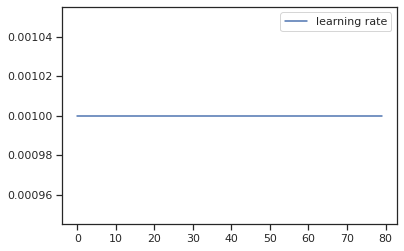

In [37]:
plt.plot(epoch_history['lr'], label='learning rate')
plt.legend()

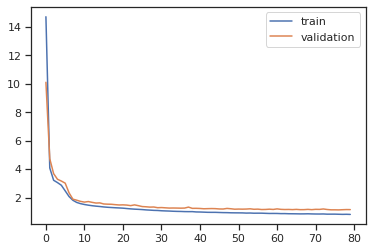

In [38]:
plt.plot(epoch_history['train_loss'], label='train')
plt.plot(epoch_history['validation_loss'], label='validation')
plt.legend()

In [39]:
torch.save(model, '/content/drive/MyDrive/Colab Notebooks/efficentDet/model-th.pth')

In [16]:
model = torch.load('/content/drive/MyDrive/Colab Notebooks/efficentDet/model-th.pth', map_location=device)

In [17]:
file = open('/content/drive/MyDrive/Colab Notebooks/efficentDet/malaria/test.json')
test_data = json.load(file)
file.close

<function TextIOWrapper.close>

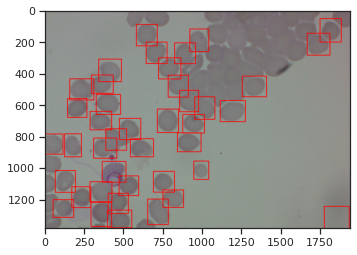

In [21]:
index = 46

threshold = 0.5
iou_threshold = 0.5

colors = {0: [255, 0, 0], #'red blood cell',
          1: [29, 52, 163],#'trophozoite',
          2: [157, 19, 212],#'schizont',
          3: [212, 19, 206],#'ring',
          4: [252, 186, 3],#'leukocyte',
          5: [28, 217, 34],#'gametocyte'
          }

image_path = '/content/drive/MyDrive/Colab Notebooks/efficentDet/malaria' + test_data[index]['image']['pathname']

image_tensor, scale = load_image(image_path)
image_tensor = torch.Tensor(image_tensor).unsqueeze(0).permute(0, 3, 1, 2).cuda()
anchore = Anchors()

with torch.no_grad():
    _, classification, regression = model(image_tensor)

    ancores = anchore(image_tensor)
    regressBoxes = BBoxTransform()
    clipBoxes = ClipBoxes()

    out = postprocess(image_tensor, ancores, regression, classification, regressBoxes, clipBoxes, threshold, iou_threshold)

img = cv2.imread(image_path)

for cls, rio, score in zip(out[0]['class_ids'], out[0]['rois'], out[0]['scores']):
    x1, y1, x2, y2 = rio / scale
    label = MalariaDataset.labels[cls]
    score = float(score)
    cv2.rectangle(img, (x1, y1), (x2, y2), colors[cls], thickness=4)

plt.imshow(img)

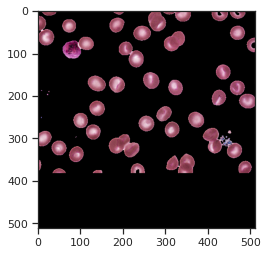

In [26]:
plt.imshow(dataset[420][0].permute(1,2,0))